# EfficientDet Exploration
by Marcelo Rovai @ Sept24

In [31]:
import tflite_runtime.interpreter as tflite
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import time

print("NumPy:", np.__version__)
print("Pillow:", Image.__version__)

NumPy: 1.23.2
Pillow: 10.4.0


In [74]:
ls models

coco_labels.txt
ei-raspi-object-detection-SSD_int8-model.lite
lite-model_efficientdet_lite0_detection_metadata_1.tflite


In [14]:
# Try to create a TFLite Interpreter
model_path = "./models/lite-model_efficientdet_lite0_detection_metadata_1.tflite"
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
print("TFLite Interpreter created successfully!")

TFLite Interpreter created successfully!


In [15]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [16]:
input_details

[{'name': 'serving_default_images:0',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 127),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([127], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [17]:
output_details

[{'name': 'StatefulPartitionedCall:3',
  'index': 598,
  'shape': array([ 1, 25,  4], dtype=int32),
  'shape_signature': array([ 1, 25,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:2',
  'index': 599,
  'shape': array([ 1, 25], dtype=int32),
  'shape_signature': array([ 1, 25], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:1',
  'index': 600,
  'shape': array([ 1, 25], dtype=int32),
  'shape_signature': array([ 1, 25], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dty

In [75]:
def load_labels(label_path):
    with open(label_path, 'r') as f:
        labels = [line.strip() for line in f.readlines()]
    return labels

In [78]:
# Load the labels
labels = load_labels('./models/coco_labels.txt')
len(labels)

91

In [79]:
labels[:20]

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'trafficlight',
 'firehydrant',
 'streetsign',
 'stopsign',
 'parkingmeter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep']

In [82]:
labels[-5:]

['scissors', 'teddybear', 'hairdrier', 'toothbrush', 'hairbrush']

In [7]:
ls images

beagles.jpg  box_2_wheel_2.jpg  cats_dogs.jpg    office.jpeg
beatch.jpg   box_3_wheel_4.jpg  home-office.jpg  ship_2.jpg
box_1.jpg    cat_dog.jpeg       man_cat_dog.jpg


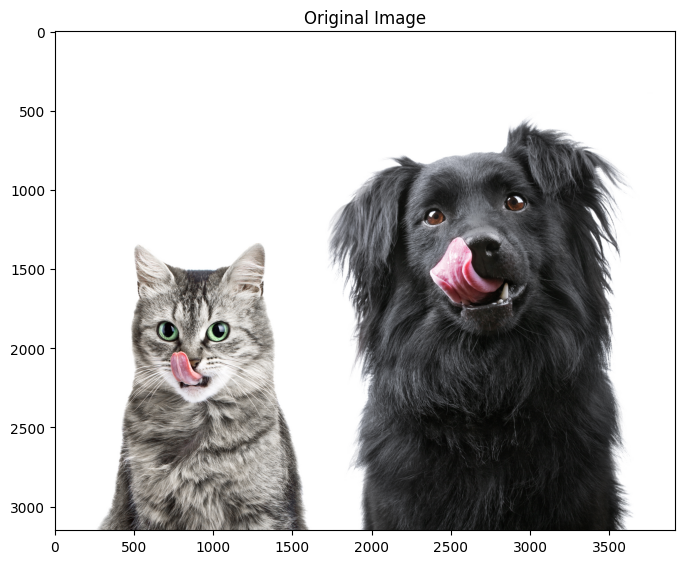

In [64]:
# Load he image
img_path = "./images/cat_dog.jpeg"
orig_img = Image.open(img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(orig_img)
plt.title("Original Image")
plt.show()

In [19]:
img = orig_img.resize((input_details[0]['shape'][1], 
                  input_details[0]['shape'][2]))
input_data = np.expand_dims(img, axis=0)
input_data.shape, input_data.dtype

((1, 320, 320, 3), dtype('uint8'))

In [20]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 1586.1ms


In [57]:
# Extract the outputs
boxes = interpreter.get_tensor(output_details[0]['index'])[0]                # Bounding boxes [1, 25, 4]
classes = interpreter.get_tensor(output_details[1]['index'])[0]             # Class IDs [1, 25] 
scores = interpreter.get_tensor(output_details[2]['index'])[0]               # Confidence scores [1, 25]
num_detections = int(interpreter.get_tensor(output_details[3]['index'])[0])  # Number of detections [1]

In [60]:
scores

array([0.7890625 , 0.7578125 , 0.1015625 , 0.07421875, 0.05859375,
       0.05078125, 0.03125   , 0.03125   , 0.02734375, 0.0234375 ,
       0.0234375 , 0.01953125, 0.01953125, 0.01953125, 0.01953125,
       0.01953125, 0.01953125, 0.015625  , 0.015625  , 0.015625  ,
       0.015625  , 0.01171875, 0.01171875, 0.01171875, 0.01171875],
      dtype=float32)

In [58]:
num_detections

25

In [59]:
classes

array([16., 17., 33., 17., 16., 16., 16., 17., 15., 16., 16., 36., 16.,
       17., 16., 16., 16., 33., 16., 17., 17., 36., 36., 33., 15.],
      dtype=float32)

In [62]:
# Post-process the results
for i in range(num_detections):
    if scores[i] > 0.5:  # Confidence threshold
        print(f"Object {i}:")
        print(f"  Bounding Box: {boxes[i]}")
        print(f"  Confidence: {scores[i]}")
        print(f"  Class: {classes[i]}")

Object 0:
  Bounding Box: [0.432578   0.04981852 0.993592   0.4255715 ]
  Confidence: 0.7890625
  Class: 16.0
Object 1:
  Bounding Box: [0.17172995 0.45071447 0.9845338  0.9297526 ]
  Confidence: 0.7578125
  Class: 17.0


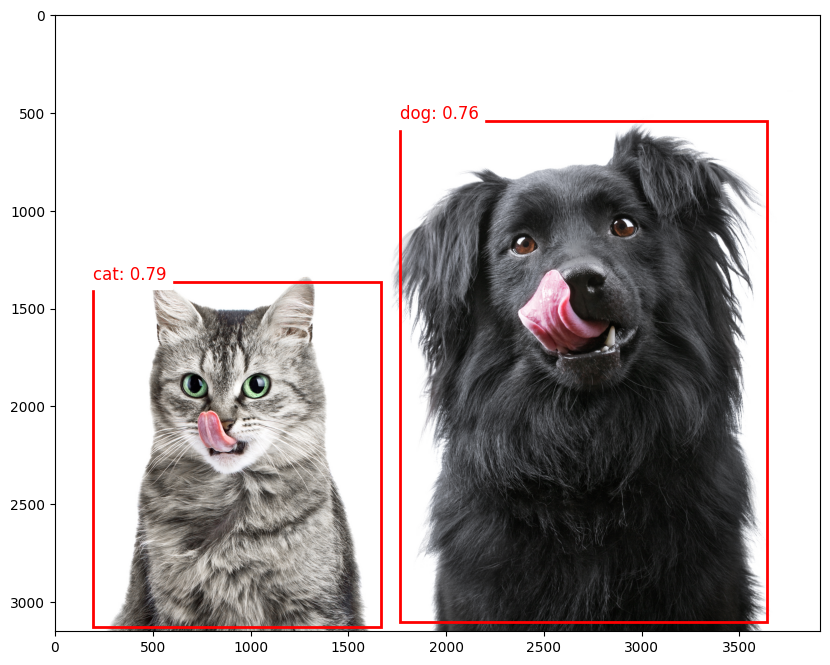

In [87]:
# Visualize the results
plt.figure(figsize=(12, 8))
plt.imshow(orig_img)
for i in range(num_detections):
    if detection_scores[i] > 0.5:  # Adjust threshold as needed
        ymin, xmin, ymax, xmax = boxes[i]
        (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                      ymin * orig_img.height, ymax * orig_img.height)
        rect = plt.Rectangle((left, top), right-left, bottom-top, 
                             fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        class_id = int(classes[i])
        class_name = labels[class_id]
        plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                 color='red', fontsize=12, backgroundcolor='white')

In [88]:
ls ./images

beagles.jpg  box_2_wheel_2.jpg  cats_dogs.jpg    office.jpeg
beatch.jpg   box_3_wheel_4.jpg  home-office.jpg  ship_2.jpg
box_1.jpg    cat_dog.jpeg       man_cat_dog.jpg


Inference time: 2261.2ms


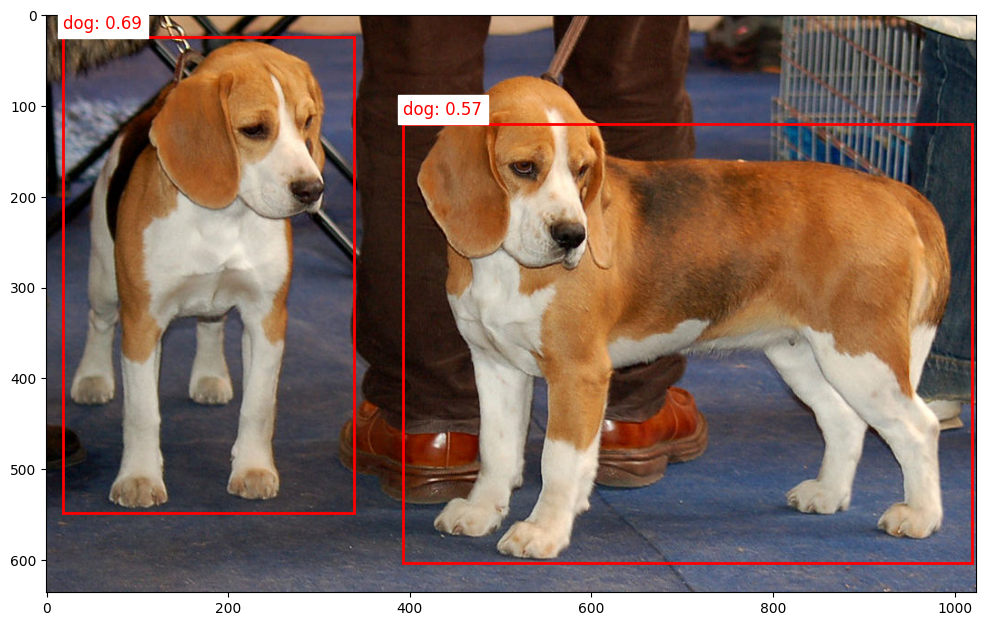

In [90]:
img_path = "./images/beagles.jpg"
orig_img = Image.open(img_path)

img = orig_img.resize((input_details[0]['shape'][1], 
                  input_details[0]['shape'][2]))
input_data = np.expand_dims(img, axis=0)

# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

# Extract the outputs
boxes = interpreter.get_tensor(output_details[0]['index'])[0]  
classes = interpreter.get_tensor(output_details[1]['index'])[0]  
scores = interpreter.get_tensor(output_details[2]['index'])[0]        
num_detections = int(interpreter.get_tensor(output_details[3]['index'])[0])

# Visualize the results
plt.figure(figsize=(12, 8))
plt.imshow(orig_img)
for i in range(num_detections):
    if detection_scores[i] > 0.5:  # Adjust threshold as needed
        ymin, xmin, ymax, xmax = boxes[i]
        (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                      ymin * orig_img.height, ymax * orig_img.height)
        rect = plt.Rectangle((left, top), right-left, bottom-top, 
                             fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        class_id = int(classes[i])
        class_name = labels[class_id]
        plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                 color='red', fontsize=12, backgroundcolor='white')

In [91]:
def detect_objects(img_path, conf=0.5):

    orig_img = Image.open(img_path)
    
    img = orig_img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    input_data = np.expand_dims(img, axis=0)
    
    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    print ("Inference time: {:.1f}ms".format(inference_time))
    
    # Extract the outputs
    boxes = interpreter.get_tensor(output_details[0]['index'])[0]  
    classes = interpreter.get_tensor(output_details[1]['index'])[0]  
    scores = interpreter.get_tensor(output_details[2]['index'])[0]        
    num_detections = int(interpreter.get_tensor(output_details[3]['index'])[0])
    
    # Visualize the results
    plt.figure(figsize=(12, 8))
    plt.imshow(orig_img)
    for i in range(num_detections):
        if detection_scores[i] > conf:  # Adjust threshold as needed
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                          ymin * orig_img.height, ymax * orig_img.height)
            rect = plt.Rectangle((left, top), right-left, bottom-top, 
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            class_id = int(classes[i])
            class_name = labels[class_id]
            plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                     color='red', fontsize=12, backgroundcolor='white')

Inference time: 3034.5ms


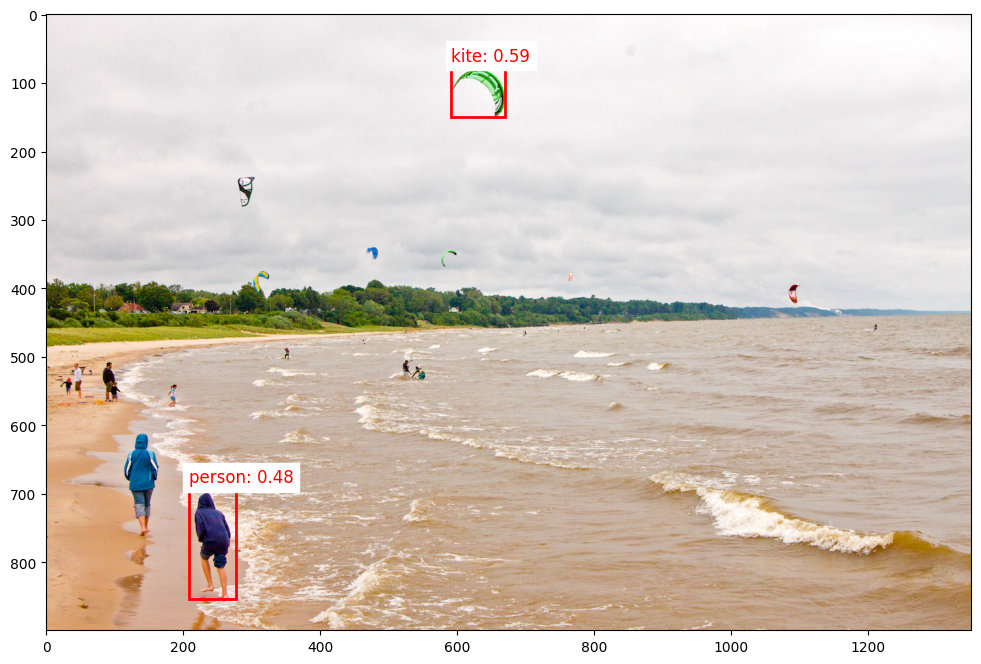

In [100]:
img_path = "./images/beatch.jpg"
detect_objects(img_path, 0.5)

Inference time: 2261.8ms


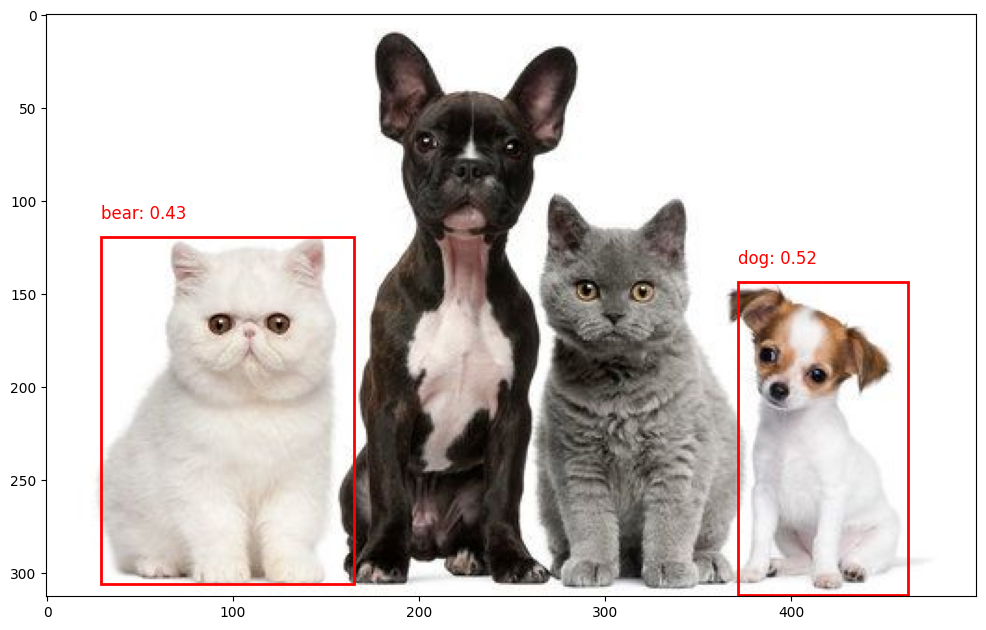

In [97]:
img_path = "./images/cats_dogs.jpg"
detect_objects(img_path, 0.5)

Inference time: 2938.6ms


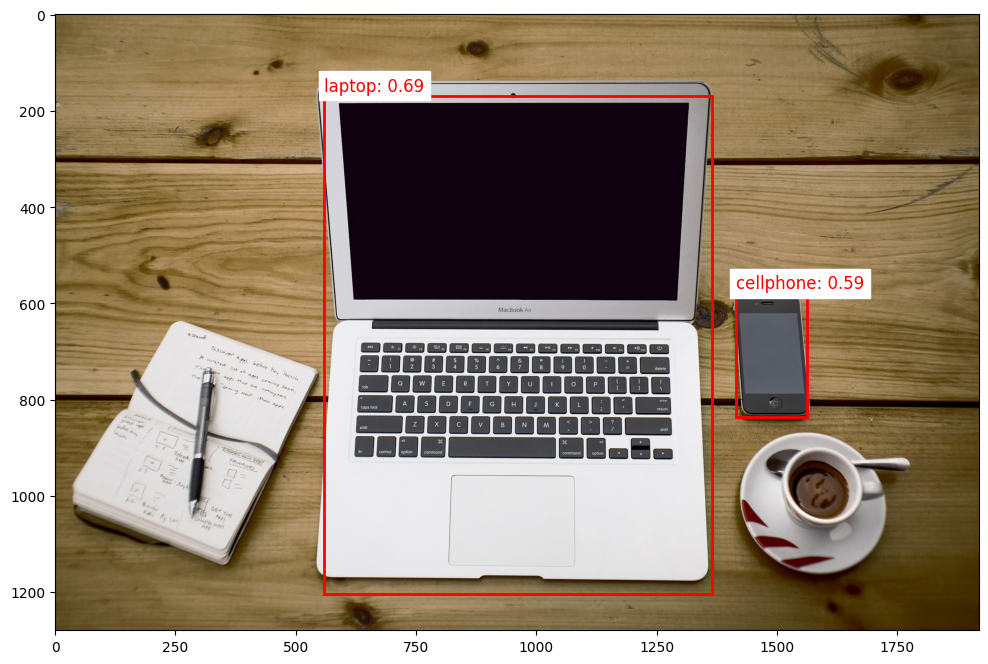

In [98]:
img_path = "./images/home-office.jpg"
detect_objects(img_path, 0.35)

Inference time: 2155.5ms


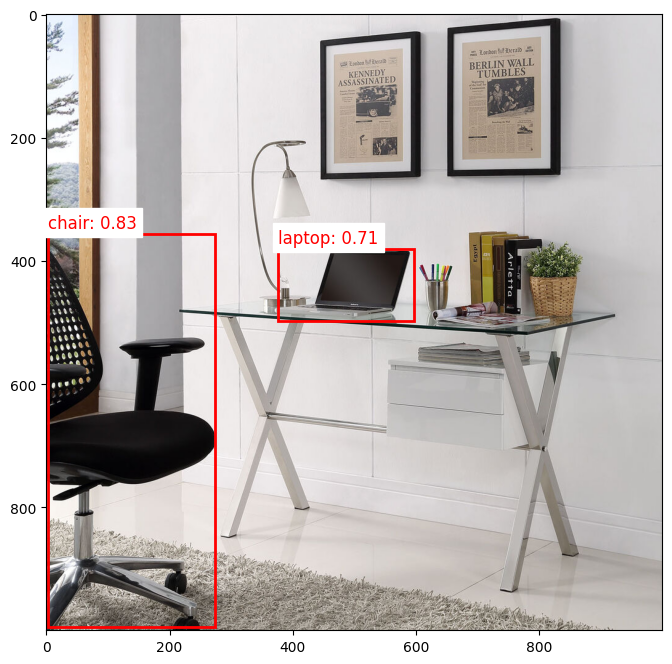

In [99]:
img_path = "./images/office.jpeg"
detect_objects(img_path, 0.5)